# Aula 03

## Feature Engineering e Seleção

### Feature engineering: O poder dos polinômios

Ao trabalharmos com dados do mundo real, não teremos uma linha reta entre os pontos, ou seja, não conseguimos determinar visualmente valores futuros. Se usarmos uma regressã linear padrão, ela tentará traçar uma reta em cima de uma curva. O resultado será bem ruim (chamado de *underfitting*). O **PolynomialFeatures** resolve isso criando 'potências' em seus dados. ele pega `x²`, `x³`, e também a interação entre vairáveis `(x1 . x2)²`

In [1]:
# Importar as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X original: [-0.32360704]
X transformado: [ 1.         -0.32360704  0.10472152]


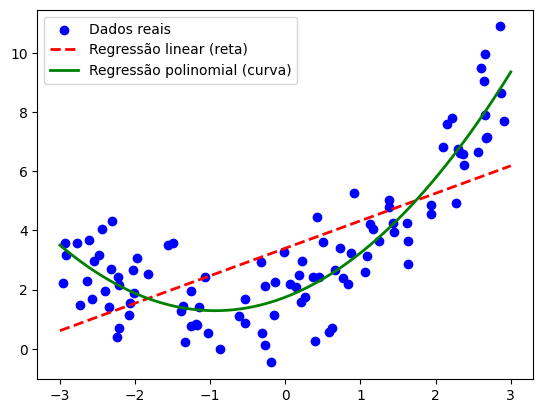

In [9]:
# Criar o nossos dados
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

# Tentativa de regressão linear (falhará)
lin_reg = LinearRegression()
lin_reg.fit(X, y)
X_novo = np.linspace(-3, 3, 100).reshape(100, 1)
y_novo = lin_reg.predict(X_novo)

# Engenharia de features: criar polinômios
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly_features.fit_transform(X)

print(f'X original: {X[0]}')
print(f'X transformado: {X_poly[0]}')

# Treinar no dado transformado
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y)
X_novo_poly = poly_features.transform(X_novo)
y_novo_poly = lin_reg_poly.predict(X_novo_poly)

# Visualização
plt.scatter(X, y, color='blue', label='Dados reais')
plt.plot(X_novo, y_novo, 'r--', label='Regressão linear (reta)', linewidth=2)
plt.plot(X_novo, y_novo_poly, 'g-', label='Regressão polinomial (curva)', linewidth=2)
plt.legend()
plt.show()

### Feature selection: menos é mais

Quando você tiver um conjunto de dados de 100, 200 colunas, será que todas elas importam? O que pode acontecer é que algumas colunas podem ser ruídos para o modelo (*overfitting*), quanto mais colunas, mais dados são necessários para o treinamento e quanto menos colunas, o treino é mais rápido. Veremos duas técnicas: uma rápida e estatística (**SelectKBest**) e uma lenta e precisa (**RFE**).

In [10]:
# Criar o dataset para seleção
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Criar o dataset
X, y = make_classification(
    n_samples=1000,
    n_features=20,  # quantidade total de colunas
    n_informative=3,  # só 3 são importantes de verdade
    n_redundant=2,  # 2 cópias das úteis
    n_repeated=0,
    n_classes=2,
    random_state=42
)

# Separar os dados
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

print(f'Formato original: {X_treino.shape}')

Formato original: (700, 20)


### SelectKBest (método de filtro)

Pense no **SelectKBest** como um vestibular. Ele faz uma prova estatística (ANOVA ou Chi-Quadrado)
com cada coluna individualmente contra o alvo `y`. As **'K'** melhores passam.

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif: Teste ANOVA para classificação (f_regression para regressão)
# k=5: As melhores 5 colunas
seletor = SelectKBest(score_func=f_classif, k=5)

# O .fit() descobre quais são as melhores colunas
# O .transform() joga fora as ruins
X_treino_selecionado = seletor.fit_transform(X_treino, y_treino)
X_teste_selecionado = seletor.transform(X_teste)

print(f'Formato após a seleção: {X_treino_selecionado.shape}')

# Ver quais colunas foram selecionadas
colunas_selecionadas = seletor.get_support()
print(f'Índices das colunas selecionadas: {[i for i, x in enumerate(colunas_selecionadas) if x]}')

Formato após a seleção: (700, 5)
Índices das colunas selecionadas: [2, 3, 5, 14, 15]


### RFE - *Recursive Feature Elimination* (método wrapper)

O **SelectKBest** olha coluna por coluna isoladamente. Mas e se duas colunas forem fracas sozinhas, mas fortes juntas? O **SelectKBest** não vê isso. O **RFE** (Eliminação Recursiva de Features) é mais inteligente, porém mais lento.

1. Ele treina o modelo com todas as colunas;
2. Analisa qual é a menos importante (baseado nos coeficientes ou feature importance);
3. Remove essa coluna e;
4. Repete o processo até que sobre **'K'** colunas desejadas.

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# O RFE precisa de um modelo base para julgar a importância
modelo_base = RandomForestClassifier(n_estimators=100, random_state=42)

# Selecionar as melhores colunas
rfe = RFE(estimator=modelo_base, n_features_to_select=3)
rfe.fit(X_treino, y_treino)

print('Colunas escolhidas pelo RFE:')
# Ranking: 1 significa que foi selecionada
for i, col in enumerate(range(X_treino.shape[1])):
  print(f'Coluna {col}: Rank: {rfe.ranking_[i]} {'(Selecionada)' if rfe.support_[i] else ""}')

Colunas escolhidas pelo RFE:
Coluna 0: Rank: 14 
Coluna 1: Rank: 7 
Coluna 2: Rank: 3 
Coluna 3: Rank: 1 (Selecionada)
Coluna 4: Rank: 5 
Coluna 5: Rank: 1 (Selecionada)
Coluna 6: Rank: 4 
Coluna 7: Rank: 11 
Coluna 8: Rank: 6 
Coluna 9: Rank: 17 
Coluna 10: Rank: 18 
Coluna 11: Rank: 12 
Coluna 12: Rank: 15 
Coluna 13: Rank: 10 
Coluna 14: Rank: 2 
Coluna 15: Rank: 1 (Selecionada)
Coluna 16: Rank: 8 
Coluna 17: Rank: 13 
Coluna 18: Rank: 16 
Coluna 19: Rank: 9 


### Transformações não-lineares (feature scaling avançado)

O que ocorre quando os dados não seguem a distribuição normal no formato padrão (sino), mas são ligeiramente tortos (skewed)? O **StandardScaler** resolve bem para distribuições no formato de sino, mas com skewed não lidam bem. Para "arrumar" essa distribuição e ajudar os modelos lineares, utilizamos transformações não-lineares como o **PowerTransformer** (Yeo-Johnson) ou logaritmo.

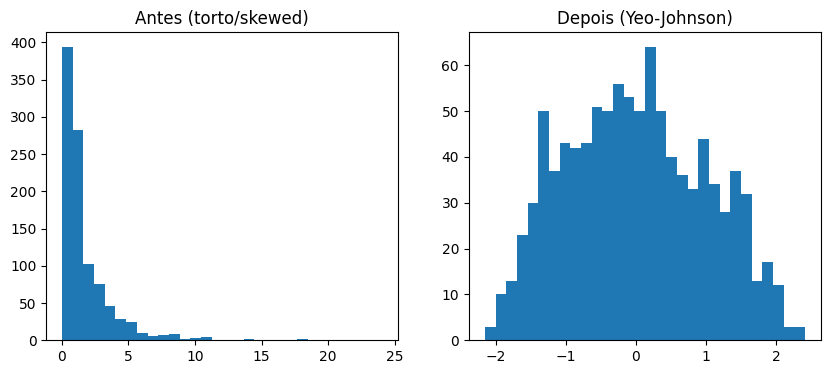

In [16]:
# Transformar uma distribuição "torta" em uma normal
from sklearn.preprocessing import PowerTransformer

# Gerar dados log-normais (tortos)
X_torto = np.random.lognormal(mean=0, sigma=1, size=(1000, 1))

# Transformar para ficar parecido com uma Gaussiana
pt = PowerTransformer(method='yeo-johnson')
X_normal = pt.fit_transform(X_torto)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(X_torto, bins=30)
ax[0].set_title('Antes (torto/skewed)')
ax[1].hist(X_normal, bins=30)
ax[1].set_title('Depois (Yeo-Johnson)')
plt.show()